# Notebook to analyze and display scRNAseq data


### Load important modules

In [3]:
# Standard modules
import numpy as np
import os
import pandas as pd 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
from scipy import linalg
from plotly.subplots import make_subplots
import ipywidgets as widgets
import logging
from sklearn import linear_model
from multiprocessing import Pool
import plotly.express as px
import scipy.cluster.hierarchy as sch
from numba import njit
# from umap import UMAP
from sklearn.cluster import KMeans
import copy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import ward, fcluster, leaves_list, optimal_leaf_ordering
import subprocess
# import tqdm as tqdm

# Move to root directory for easier module handling
os.chdir("../..")
print(os.listdir("."))

#LBAE imports
from modules.maldi_data import MaldiData
from modules.figures import Figures
from modules.atlas import Atlas
from modules.launch import Launch
from modules.storage import Storage
from modules.scRNAseq import ScRNAseq

# multithreading/multiprocessing
from multiprocessing import Pool
import multiprocessing
from threadpoolctl import threadpool_limits

# set thread limit
threadpool_limits(16)


['.git', '.gitattributes', '.vscode', 'LICENSE.md', 'app.py', 'assets', 'config.py', 'data_sample', 'index.py', 'js', 'main.py', 'modules', 'notebooks', 'pages', 'readme', 'style', 'data', 'README.md', '.ipynb_checkpoints', 'Dockerfile', '.mypy_cache', '.gitignore', '.github', 'mkdocs.yml', 'docs', 'in_app_documentation', 'site', 'requirements.txt', 'remaining_TODOs.md', '__pycache__', 'nohup.out', 'scatter_lipids_metabolites.pdf', 'scatter_singlelipids_metabolites.pdf', 'test.png', 'scatter_lipids_allgenes.pdf', 'scatter_singlelipids_allgenes.pdf', 'output.png', 'R2_comparison.pdf']


### Load LBAE objects

In [4]:
path_data = "data/whole_dataset/"
path_annotations = "data/annotations/"
path_db = "data/app_data/data.db"

# Load shelve database
storage = Storage(path_db)

# Load data
data = MaldiData(path_data, path_annotations)

# Load Atlas and Figures objects. At first launch, many objects will be precomputed and shelved in
# the classes Atlas and Figures.
atlas = Atlas(data, storage, resolution=25, sample = True)
scRNAseq = ScRNAseq()
figures = Figures(data, storage, atlas, scRNAseq, sample=True)

brain_1 = False

#### Load genes and lipids arrays 

In [5]:
# lipids
# array_exp_lipids = np.load('data/scRNAseq/array_exp_lipids_' + str(brain_1) + '.npy')
array_exp_lipids = np.log1p(np.load('data/scRNAseq/array_exp_lipids_' + str(brain_1) + '.npy'))
# genes
array_exp_genes = np.load('data/scRNAseq/total_array_exp_genes_' + str(brain_1) + '.npy')
# array_exp_genes = np.log1p(np.load('data/scRNAseq/total_array_exp_genes_' + str(brain_1) + '.npy'))
l_name_lipids = np.load('data/scRNAseq/array_name_lipids_' + str(brain_1) + '.npy').tolist()
l_genes = np.load('data/scRNAseq/total_array_name_genes_' + str(brain_1) + '.npy').tolist()
# array_coef = np.load('data/scRNAseq/array_coef_' + str(brain_1) + '.npy')
# l_score = np.load('data/scRNAseq/array_score_' + str(brain_1) + '.npy').tolist()
xmol, ymol, zmol = np.load('data/scRNAseq/array_coordinates.npy')

print(len(l_genes))

/tmp/ipykernel_12966/1950584436.py:3: RuntimeWarning:

invalid value encountered in log1p



15326


In [6]:
ix_genes_select = np.argwhere(array_exp_genes.sum(axis=0) > 0.1e6).flatten()
array_exp_genes = array_exp_genes[:,ix_genes_select]
l_genes = np.array(l_genes)[ix_genes_select]

print(len(ix_genes_select))

2528


In [73]:
# log the values
array_exp_genes = np.log1p(array_exp_genes)

In [74]:
# replace nan values with median value in column
values_median = np.nanmean(array_exp_lipids, axis=0)
inds = np.where(np.isnan(array_exp_lipids))
array_exp_lipids[inds] = np.take(values_median, inds[1])

In [75]:
# centering, variance normalization
mean = array_exp_lipids.mean(axis=0)
var = array_exp_lipids.var(axis=0)
array_exp_lipids = (array_exp_lipids - mean) /var 

# centering, variance normalization
mean = array_exp_genes.mean(axis=0)
var = array_exp_genes.var(axis=0)
array_exp_genes = (array_exp_genes - mean) /var 

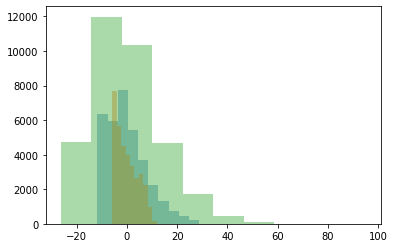

In [76]:
for i in [0,4,6]:
    plt.hist(array_exp_lipids[:,i], alpha=0.4)
plt.show()

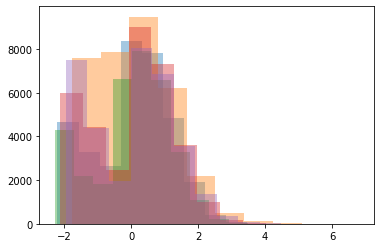

In [77]:
for i in [0,4,6,15,40]:
    plt.hist(array_exp_genes[:,i], alpha=0.4)
plt.show()

In [78]:
from sklearn.svm import SVR
from sklearn import linear_model


In [79]:
gene_ontology_1 = pd.read_csv('/home/colas/lbae/notebooks/scRNAseq/data/geneontology_metabolites_1.csv', sep='\t', header=None)
gene_ontology_2 = pd.read_csv('/home/colas/lbae/notebooks/scRNAseq/data/geneontology_metabolites_2.csv', sep='\t', header=None)
gene_ontology = pd.concat([gene_ontology_1, gene_ontology_2])

In [80]:
gene_ontology.fillna('', inplace=True)

genes_metabolic = gene_ontology[2].astype(object).apply(lambda x: x.split('|')).explode().to_list()
genes_metabolic += gene_ontology[3].tolist()
genes_metabolic = [x.lower() for x in genes_metabolic]

indexes_genes_metabolic = [(i, p) for (i, p) in enumerate(l_genes) if p.lower() in genes_metabolic]
indexes_genes_metabolic_int = np.array(indexes_genes_metabolic)[:,0].astype(int)

In [59]:
# gene_ontology = pd.read_csv('/home/colas/lbae/notebooks/scRNAseq/data/geneontology_metabolites.csv', sep='\t', header=None)
# gene_ontology.fillna('', inplace=True)

# genes_metabolic = gene_ontology[0].astype(object).apply(lambda x: x.split('|')).explode().to_list()
# genes_metabolic += gene_ontology[1].tolist()
# genes_metabolic = [x.lower() for x in genes_metabolic]

# indexes_genes_metabolic = [(i, p) for (i, p) in enumerate(l_genes) if p.lower() in genes_metabolic]
# indexes_genes_metabolic_int = np.array(indexes_genes_metabolic)[:,0].astype(int)

# Scatterplot based on metabolic genes

In [81]:
# random subset of voxels
array_exp_genes.shape

(34053, 2528)

In [82]:
np.random.seed(30)
ix_voxels = np.random.choice(len(array_exp_genes), 10000)

In [83]:
print(len(indexes_genes_metabolic_int))

201


In [84]:
scores = []
y_pred_list = []
for i in tqdm.tqdm(range(len(l_name_lipids))):
    #regr = SVR(C=1.0, epsilon=0.2)
    regr = linear_model.Lasso(alpha=0.1)
    y = array_exp_lipids[ix_voxels,i]
    regr.fit(array_exp_genes[ix_voxels][:,indexes_genes_metabolic_int], y)
    y_pred = regr.predict(array_exp_genes[ix_voxels][:, indexes_genes_metabolic_int])
    score = regr.score(array_exp_genes[ix_voxels][:,indexes_genes_metabolic_int], y)

    # append to lists
    scores.append(score)
    y_pred_list.append(y_pred)

scores = np.array(scores)

100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


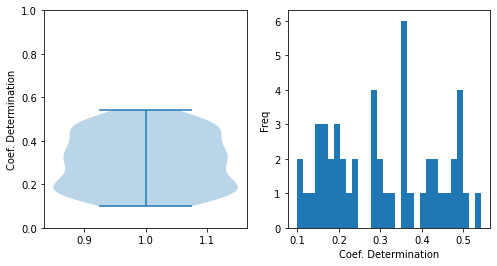

In [85]:
fig = plt.figure(None,(8,4))
gs = plt.GridSpec(1,2)

plt.subplot(gs[0])
# show histogram of coefficients of determination
# plt.hist(scores, bins=30, range=(0,1))
plt.violinplot(scores[scores>0], widths=0.3, bw_method=0.4)
# plt.boxplot(scores[scores>0])
plt.ylim([0,1])
# plt.xlabel('Frequency')
plt.ylabel('Coef. Determination')
# plt.title('log gene values')


plt.subplot(gs[1])
plt.hist(scores, bins=30)

# plt.boxplot(scores[scores>0])
# plt.ylim([0,1])
# plt.xlabel('Frequency')
plt.ylabel('Freq')
plt.xlabel('Coef. Determination')

plt.show()

In [15]:
# fig.savefig('r2_metabolites_violin.pdf')

In [86]:
# show a scatter plot of ground truth lipid values in one pixel, against the predicted lipid values
y_pred_list = np.array(y_pred_list)

(-33.119468688964844, 26.54390192031861)

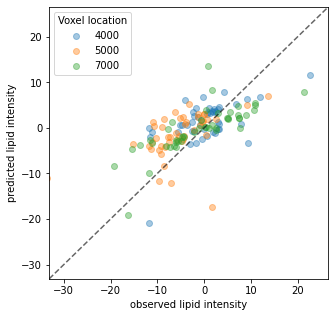

In [104]:
fig = plt.figure(None,(5,5))
for index_pixel in [4000,5000,7000]:
    # index_pixel = 4000
    plt.scatter(array_exp_lipids[ix_voxels[index_pixel],:],y_pred_list[:,index_pixel], alpha=0.4, label=index_pixel)
    plt.xlabel('observed lipid intensity')
    plt.ylabel('predicted lipid intensity')

plt.legend(title='Voxel location')
xmax = max(np.percentile(array_exp_lipids,97),np.percentile(y_pred_list,97))
xmin = min(np.percentile(array_exp_lipids,2),np.percentile(y_pred_list,2))
plt.plot(np.arange(xmin,xmax,0.1), np.arange(xmin,xmax, 0.1), linestyle='--', alpha=0.6, color='k')
# set limits
plt.xlim([xmin,xmax])
plt.ylim([xmin,xmax])


In [105]:
fig.savefig('scatter_lipids_metabolites.pdf')


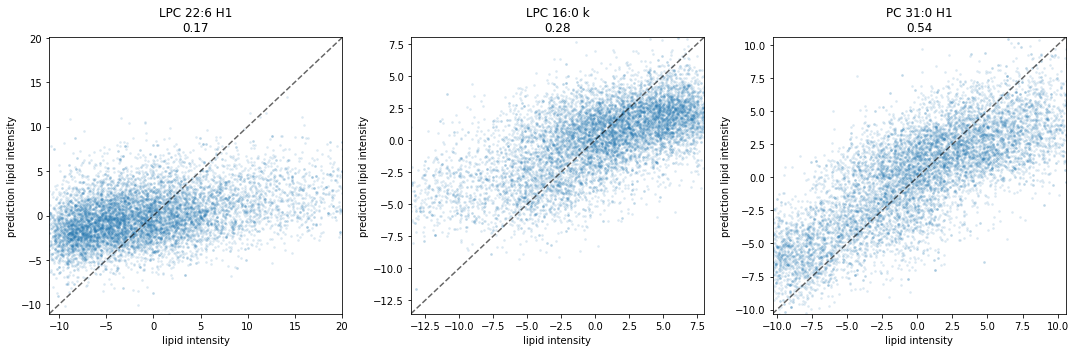

In [106]:
# show full scatter plot for 3 lipids
fig = plt.figure(None,(15,5))
gs = plt.GridSpec(1,3)

# np.argsort(scores)[[16,30,49]] 
for i_, i_lipid in enumerate([21,10,41]):
    plt.subplot(gs[i_])
    plt.scatter(array_exp_lipids[ix_voxels,i_lipid], y_pred_list[i_lipid], alpha=0.1,s=3,rasterized=True)
    plt.title(f'{l_name_lipids[i_lipid]}\n{scores[i_lipid]:.2f}')

    xmax = max(np.percentile(array_exp_lipids[ix_voxels,i_lipid],97),np.percentile(y_pred_list[i_lipid],97))
    xmin = min(np.percentile(array_exp_lipids[ix_voxels,i_lipid],2),np.percentile(y_pred_list[i_lipid],2))
    plt.plot(np.arange(xmin,xmax,0.01), np.arange(xmin,xmax, 0.01), linestyle='--', alpha=0.6, color='k')

    # set limits
    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])

    plt.xlabel('lipid intensity')
    plt.ylabel('prediction lipid intensity')

plt.tight_layout()


In [107]:
fig.savefig('scatter_singlelipids_metabolites.pdf')

# Using all genes

In [90]:
scores_allgenes = []
y_pred_list_allgenes = []
for i in tqdm.tqdm(range(len(l_name_lipids))):
    #regr = SVR(C=1.0, epsilon=0.2)
    regr = linear_model.Lasso(alpha=0.1)
    y = array_exp_lipids[ix_voxels,i]
    regr.fit(array_exp_genes[ix_voxels], y)
    y_pred = regr.predict(array_exp_genes[ix_voxels])
    score = regr.score(array_exp_genes[ix_voxels], y)

    # append to lists
    scores_allgenes.append(score)
    y_pred_list_allgenes.append(y_pred)

scores_allgenes = np.array(scores_allgenes)

 14%|█▍        | 7/50 [01:11<08:47, 12.26s/it]/home/halima/anaconda3/envs/lbae/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.488e+03, tolerance: 4.745e+02

 50%|█████     | 25/50 [04:47<05:23, 12.94s/it]/home/halima/anaconda3/envs/lbae/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e+04, tolerance: 5.978e+02

 58%|█████▊    | 29/50 [05:49<05:06, 14.58s/it]/home/halima/anaconda3/envs/lbae/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

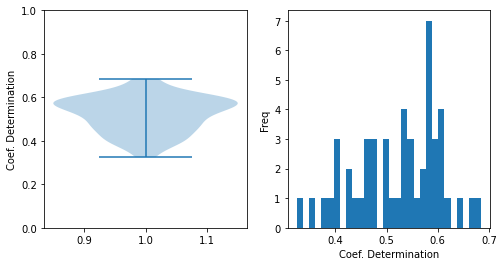

In [98]:
fig = plt.figure(None,(8,4))
gs = plt.GridSpec(1,2)

plt.subplot(gs[0])
# show histogram of coefficients of determination
# plt.hist(scores, bins=30, range=(0,1))
plt.violinplot(scores_allgenes[scores_allgenes>0], widths=0.3, bw_method=0.4)
# plt.boxplot(scores[scores>0])
plt.ylim([0,1])
# plt.xlabel('Frequency')
plt.ylabel('Coef. Determination')
# plt.title('log gene values')


plt.subplot(gs[1])
plt.hist(scores_allgenes, bins=30)

# plt.boxplot(scores[scores>0])
# plt.ylim([0,1])
# plt.xlabel('Frequency')
plt.ylabel('Freq')
plt.xlabel('Coef. Determination')

plt.show()

In [92]:
# fig.savefig('r2_allgenes_violin.pdf')

In [99]:
# show a scatter plot of ground truth lipid values in one pixel, against the predicted lipid values
y_pred_list_allgenes = np.array(y_pred_list_allgenes)

(-33.119468688964844, 26.54390192031861)

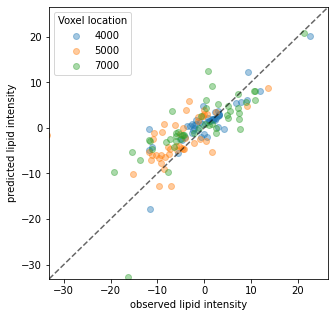

In [108]:
fig = plt.figure(None,(5,5))
for index_pixel in [4000,5000,7000]:
    # index_pixel = 4000
    plt.scatter(array_exp_lipids[ix_voxels[index_pixel],:],y_pred_list_allgenes[:,index_pixel], alpha=0.4, label=index_pixel)
    plt.xlabel('observed lipid intensity')
    plt.ylabel('predicted lipid intensity')

plt.legend(title='Voxel location')
xmax = max(np.percentile(array_exp_lipids,97),np.percentile(y_pred_list_allgenes,97))
xmin = min(np.percentile(array_exp_lipids,2),np.percentile(y_pred_list_allgenes,2))
plt.plot(np.arange(xmin,xmax,0.1), np.arange(xmin,xmax, 0.1), linestyle='--', alpha=0.6, color='k')
# set limits
plt.xlim([xmin,xmax])
plt.ylim([xmin,xmax])


In [109]:
fig.savefig('scatter_lipids_allgenes.pdf')

In [26]:
np.argsort(scores)[[16,30,49]]

array([29, 11,  5])

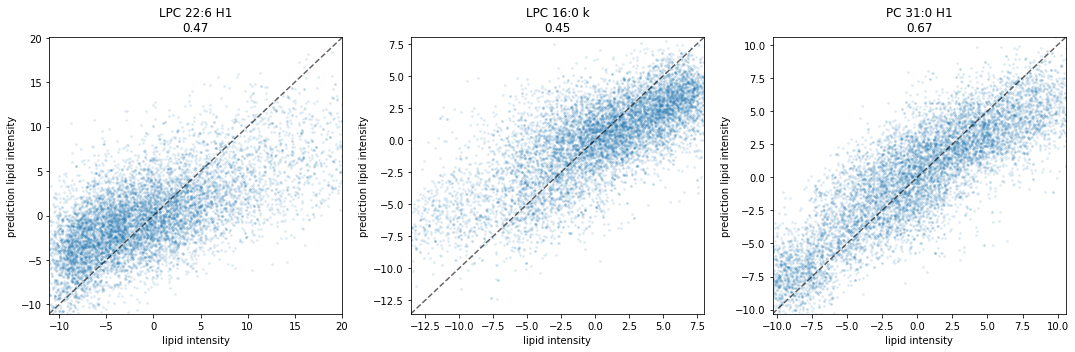

In [110]:
# show full scatter plot for 3 lipids
fig = plt.figure(None,(15,5))
gs = plt.GridSpec(1,3)

# np.argsort(scores)[[16,30,49]] 
for i_, i_lipid in enumerate([21,10,41]):
    plt.subplot(gs[i_])
    plt.scatter(array_exp_lipids[ix_voxels,i_lipid], y_pred_list_allgenes[i_lipid], alpha=0.1,s=3,rasterized=True)
    plt.title(f'{l_name_lipids[i_lipid]}\n{scores_allgenes[i_lipid]:.2f}')

    xmax = max(np.percentile(array_exp_lipids[ix_voxels,i_lipid],97),np.percentile(y_pred_list_allgenes[i_lipid],97))
    xmin = min(np.percentile(array_exp_lipids[ix_voxels,i_lipid],2),np.percentile(y_pred_list_allgenes[i_lipid],2))
    plt.plot(np.arange(xmin,xmax,0.01), np.arange(xmin,xmax, 0.01), linestyle='--', alpha=0.6, color='k')

    # set limits
    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])

    plt.xlabel('lipid intensity')
    plt.ylabel('prediction lipid intensity')

plt.tight_layout()


In [111]:
fig.savefig('scatter_singlelipids_allgenes.pdf')

In [96]:
scores_allgenes

array([0.57842804, 0.54974512, 0.5870592 , 0.50243509, 0.5950667 ,
       0.60473118, 0.64887946, 0.58786957, 0.60651347, 0.38316901,
       0.44753754, 0.49922122, 0.45887862, 0.39312325, 0.42129849,
       0.35704208, 0.43643436, 0.57783738, 0.60265874, 0.54369413,
       0.42491549, 0.46808445, 0.39688388, 0.47056578, 0.32441088,
       0.53547481, 0.54574183, 0.58014978, 0.54032464, 0.5387777 ,
       0.40723735, 0.39733064, 0.58058793, 0.47957808, 0.49819898,
       0.68513686, 0.59225515, 0.58913257, 0.5779431 , 0.52889179,
       0.46909469, 0.66977884, 0.60268227, 0.57119515, 0.56710345,
       0.50512744, 0.55532093, 0.52801697, 0.6168749 , 0.46623923])

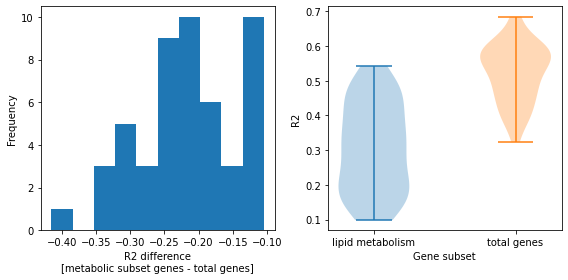

In [112]:
fig = plt.figure(None,(8,4))
gs = plt.GridSpec(1,2)

plt.subplot(gs[0])
plt.hist(scores - scores_allgenes)
plt.xlabel('R2 difference\n[metabolic subset genes - total genes]')
plt.ylabel('Frequency')

plt.subplot(gs[1])

plt.violinplot(scores, positions=[0])
plt.violinplot(scores_allgenes, positions=[1])
plt.ylabel('R2')
plt.xlabel('Gene subset')
plt.xticks(np.arange(2), ['lipid metabolism', 'total genes'])


plt.tight_layout()
plt.show()

In [113]:
fig.savefig('R2_comparison.pdf')

In [ ]:
scores = []

for i in tqdm.tqdm(range(len(l_genes))):
    regr = SVR(C=1.0, epsilon=0.2)
    y = array_exp_lipids[:,i]
    regr.fit(array_exp_genes, y)
    # y_pred = regr.predict(array_exp_genes)
    score = regr.score(array_exp_genes, y)
    scores.append(score)


KeyboardInterrupt: 

Text(0.5, 1.0, 'R2 score: 0.3646605259110044')

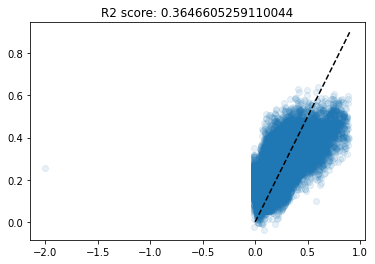

In [ ]:
plt.scatter(y, y_pred, alpha=0.1)
plt.plot(np.arange(0,1,0.1), np.arange(0,1,0.1), linestyle='--', color='k')
plt.title(f'R2 score: {score}')

#### Plot LASSO regression

In [ ]:
# Compute correlation on rows
pairwise_distances = sch.distance.pdist(array_coef)
linkage = sch.linkage(pairwise_distances, method='ward')
cluster_distance_threshold = pairwise_distances.max()/2
idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                    criterion='distance')
idx = np.argsort(idx_to_cluster_array)
    
corr_array_clustered = array_coef[idx, :]
l_name_lipids = np.array(l_name_lipids)[idx]
l_score = np.array(l_score)[idx]

# Compute correlation on columns
pairwise_distances = sch.distance.pdist(corr_array_clustered.T)
linkage = sch.linkage(pairwise_distances, method='ward')
cluster_distance_threshold = pairwise_distances.max()/2
idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                    criterion='distance')
idx = np.argsort(idx_to_cluster_array)
    
corr_array_clustered = corr_array_clustered[:, idx]
l_genes = np.array(l_genes)[idx]


In [ ]:
print(corr_array_clustered.shape)

(50, 90)


In [ ]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True,horizontal_spacing=0.)


g1 = go.Heatmap(z = corr_array_clustered, colorscale='RdBu', x=l_genes, y = l_name_lipids, zmin = -0.002, zmax = 0.002, colorbar=dict(title="Coef value", x=1.1 ))
g2 = go.Heatmap(z = np.array([l_score]).T, colorscale='mint', y = l_name_lipids, zmin = 0., zmax = 0.6, colorbar=dict(title="R2 score", x=1.05 ))


fig.append_trace(g1, row=1, col=1)
fig.append_trace(g2, row=1, col=2)



# edit axis labels
fig['layout']['xaxis']['title']="Genes"
fig['layout']['yaxis']['title']='Lipids'
#fig['layout']['xaxis2']['title']='R2 score'
fig['layout']['xaxis2']['side']='top'

fig.update_xaxes(showticklabels=False, row=1, col=2)
fig.update_yaxes(showticklabels=False, row=1, col=2)

fig['layout']['yaxis2']['scaleanchor']='x2'
fig['layout']['yaxis']['scaleanchor']='x'

fig['layout']['xaxis']['domain'] = [0, 0.98]
fig['layout']['xaxis2']['domain'] = [0.99, 1]
#fig.update_traces(showscale=False)
fig.update_xaxes(tickangle=45)
#fig.update_layout(coloraxis_colorbar_x=-0.15)

    


fig.update_layout(
    width=int(1520),
    height=int(700),
    font_size=7,
    title_font_size=12,
    title={
        'text' : 'Elastic Net regression factors (MALDI lipids data with gene expression as predictors)',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')


fig.show()
# fig.write_image("notebooks/scRNAseq/output/heatmap.pdf")


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


#### Make an interactive widget displaying a clustergram of lipid and gene expression when one clicks on the corresponding dot

In [ ]:
# Get root figure
root_data = figures._storage.return_shelved_object(
    "figures/3D_page",
    "volume_root",
    force_update=False,
    compute_function=figures.compute_3D_root_volume,
)

# Get scatter figure for the scRNAseq spots
scatter = go.Scatter3d(
    x=xmol,
    y=ymol,
    z=zmol,
    mode='markers',
    marker=dict(
        size=2,
        opacity=0.8
    ),
)


root_data['hoverinfo']= 'skip'
scatter['hoverinfo']= "all"

In [ ]:
plot_widget = True
f = None
if plot_widget:
    fig = make_subplots(rows=1, cols=6, specs=[[{'type': 'surface', "colspan": 4},  {'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]])
    fig.add_trace(root_data,row=1, col=1)
    fig.add_trace(scatter,row=1, col=1)

    n_to_keep = 53

    # Sort array according to most expressed genes and lipid for spot 0
    index_init = 0
    array_init_genes, l_genes_init = zip(*sorted(zip(array_exp_genes[index_init:index_init+1,:].T, l_genes), reverse=True))
    array_init_genes = np.array(array_init_genes)[:n_to_keep]
    l_genes_init = l_genes_init[:n_to_keep]
    array_init_lipids, l_lipids_init = zip(*sorted(zip(array_exp_lipids[index_init:index_init+1,:].T, l_name_lipids), reverse=True))
    array_init_lipids = np.array(array_init_lipids)[:n_to_keep]
    l_lipids_init = l_lipids_init[:n_to_keep]

    g1 = go.Heatmap(z = array_init_genes, colorscale='mint', y=l_genes_init)#, xaxis="x2", yaxis="y2", )
    g2 = go.Heatmap(z = array_init_lipids, colorscale='mint', y = l_lipids_init )#, xaxis="x3", yaxis="y3", )


    fig.add_trace(g1, row=1, col=5)
    fig.add_trace(g2, row=1, col=6)


    fig.data[2].showscale=False
    fig.data[3].showscale=False



    #fig.add_trace(go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),row=1, col=2)

    f = go.FigureWidget(fig)
    p1 = f.data[1]
    p2 = f.data[2]
    p3 = f.data[3]



    # Hide grey background
    f.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
        scene=dict(
            xaxis=dict(backgroundcolor="rgba(0,0,0,0)"),
            yaxis=dict(backgroundcolor="rgba(0,0,0,0)"),
            zaxis=dict(backgroundcolor="rgba(0,0,0,0)"),
        ),
        template = "plotly_dark",
        plot_bgcolor = "rgba(0,0,0,0)",
        paper_bgcolor = "rgba(0,0,0,0)",

        xaxis=dict(
                domain=[0.7, 0.75]
            ),
        xaxis2=dict(
                domain=[0.90, 0.95]
            ),
        #xaxis3=dict(
        #        domain=[0.75, 1],
        #),
    )

    f['layout']['yaxis2']['scaleanchor']='x2'
    f['layout']['yaxis']['scaleanchor']='x'



    f.update_layout(
        #width=int(1200*1.2),
        #height=int(700*1.2),
        font_size=7,
        title_font_size=12,
        title={
            'text' : 'Click on a dot to display the corresponding data',
            'y':0.92,
            'x':0.3,
            'xanchor': 'center',
            'yanchor': 'top'}
    )


    #print(f['layout'])
    #f['layout']['xaxis']['domain'] = [0, 0.96]
    #f['layout']['xaxis2']['domain'] = [0.96, 0.98]
    #f['layout']['xaxis3']['domain'] = [0.98, 1.]

    f.layout.hovermode = 'closest'


    # Set background color to zero
    fig.layout.template = "plotly_dark"
    fig.layout.plot_bgcolor = "rgba(0,0,0,0)"
    fig.layout.paper_bgcolor = "rgba(0,0,0,0)"


    # create our callback function
    debug_view = widgets.Output(layout={'border': '1px solid black'})
    @debug_view.capture(clear_output=True)
    def update(trace, points, selector):
        #global p2
        #global p3
        for i in points.point_inds:

            index_init = i
            array_init_genes, l_genes_init = zip(*sorted(zip(array_exp_genes[index_init:index_init+1,:].T, l_genes), reverse=True))
            array_init_genes = np.array(array_init_genes)[:n_to_keep]
            l_genes_init = l_genes_init[:n_to_keep]
            array_init_lipids, l_lipids_init = zip(*sorted(zip(array_exp_lipids[index_init:index_init+1,:].T, l_name_lipids), reverse=True))
            array_init_lipids = np.array(array_init_lipids)[:n_to_keep]
            l_lipids_init = l_lipids_init[:n_to_keep]

            with f.batch_update():

                p2.y = l_genes_init
                p2.z = array_init_genes
                p3.y = l_lipids_init
                p3.z = array_init_lipids

    p1.on_click(update)
f

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                             'r…

In [ ]:
if plot_widget:
    debug_view

#### Cluster pixel according to genes and lipids and compare

In [ ]:
print(array_exp_genes.shape, array_exp_lipids.shape)

(34053, 90) (34053, 50)


In [ ]:
# Compute a UMAP projection and do clustering on the result
umap_2d_lipids = UMAP(n_components=2, init='random', random_state=0)
proj_2d_lipids = umap_2d_lipids.fit_transform(array_exp_lipids)
kmeans_lipids = KMeans(n_clusters=100, random_state=0).fit(proj_2d_lipids)

y = pdist(kmeans_lipids.cluster_centers_)
Z = ward(y)
leaves_ordered = list(leaves_list(optimal_leaf_ordering(Z, y)))

l_colors_lipids = []
for label in kmeans_lipids.labels_:
    l_colors_lipids.append(leaves_ordered.index(label))

/home/halima/anaconda3/envs/lbae/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
fig = go.Figure(data=go.Scattergl(
    x = proj_2d_lipids[:,0],
    y = proj_2d_lipids[:,1],
    mode='markers',
    marker=dict(
        color = l_colors_lipids,
        size=4,
        opacity = 0.4,
        colorscale = px.colors.sequential.Jet,
    )
))


fig.update_traces(textposition='top center', textfont_size=8, showlegend=False)
fig.update_layout(
    width=int(800),
    height=int(800),
    font_size=7,
    title_font_size=12,
    title={
        'text' : 'UMAP and K-Means voxel clustering using lipidomics (MALDI) data',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    template='simple_white'
)
fig.show()
fig.write_image("notebooks/scRNAseq/output/umap1.pdf")


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
# Compute a UMAP projection and do clustering on the result
umap_2d_genes = UMAP(n_components=2, init='random', random_state=0)
proj_2d_genes = umap_2d_genes.fit_transform(array_exp_genes)
kmeans_genes = KMeans(n_clusters=10, random_state=0).fit(proj_2d_genes)

y = pdist(kmeans_genes.cluster_centers_)
Z = ward(y)
leaves_ordered = list(leaves_list(optimal_leaf_ordering(Z, y)))

l_colors_genes = []
for label in kmeans_genes.labels_:
    l_colors_genes.append(leaves_ordered.index(label))
    

In [ ]:
fig = go.Figure(data=go.Scattergl(
    x = proj_2d_genes[:,0],
    y = proj_2d_genes[:,1],
    mode='markers',
    marker=dict(
        color = l_colors_genes,
        size=4,
        opacity = 0.4,
        colorscale = px.colors.sequential.Jet,
    )
))


fig.update_traces(textposition='top center', textfont_size=8, showlegend=False)
fig.update_layout(
    width=int(800),
    height=int(800),
    font_size=7,
    title_font_size=12,
    title={
        'text' : 'UMAP and K-Means voxel clustering using gene (scRNAseq) data',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    template='simple_white'
)
fig.show()
fig.write_image("notebooks/scRNAseq/output/umap2.pdf")



In [ ]:
fig = go.Figure(data=go.Scattergl(
    x = proj_2d_genes[:,0],
    y = proj_2d_genes[:,1],
    mode='markers',
    marker=dict(
        color = l_colors_lipids,
        size=4,
        opacity = 0.4,
        colorscale = px.colors.sequential.Jet,
    )
))


fig.update_traces(textposition='top center', textfont_size=8, showlegend=False)
fig.update_layout(
    width=int(800),
    height=int(800),
    font_size=7,
    title_font_size=12,
    title={
        'text' : 'UMAP voxel gene data (scRNAseq) projection using Lipid data (MALDI) for clustering',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    template='simple_white'
)

fig.show()
fig.write_image("notebooks/scRNAseq/output/umap3.pdf")




In [ ]:
fig = go.Figure(data=go.Scattergl(
    x = proj_2d_lipids[:,0],
    y = proj_2d_lipids[:,1],
    mode='markers',
    marker=dict(
        color = l_colors_genes,
        size=4,
        opacity = 0.4,
        colorscale = px.colors.sequential.Jet,
    )
))


fig.update_traces(textposition='top center', textfont_size=8, showlegend=False)
fig.update_layout(
    width=int(800),
    height=int(800),
    font_size=7,
    title_font_size=12,
    title={
        'text' : 'UMAP lipid data (MALDI) projection using gene data (scRNAseq) for clustering',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    template='simple_white'
)

fig.show()
fig.write_image("notebooks/scRNAseq/output/umap4.pdf")

### Project back cluster in brain space

In [ ]:
if True:
    scatter = go.Scatter3d(
        x=xmol,
        y=zmol,
        z=-ymol,
        mode='markers',
        marker=dict(
            size=1,
            color=l_colors_lipids,
            opacity=1.,
            colorscale = px.colors.sequential.Jet,
        ),
    )
    scatter['hoverinfo']= "all"



    # Get root figure
    root_data = figures._storage.return_shelved_object(
        "figures/3D_page",
        "volume_root",
        force_update=False,
        compute_function=figures.compute_3D_root_volume,
    )

    root_data_y = copy.deepcopy(root_data['y'])
    root_data_z = copy.deepcopy(root_data['z'])
    root_data['y'] = root_data_z 
    root_data['z'] = -root_data_y
    root_data['hoverinfo']= 'skip'



    fig = go.Figure(data=[root_data, scatter])


    # Hide grey background
    fig.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
            scene=dict(
                xaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="rgba(0,0,0,0)", gridcolor="rgba(0,0,0,0)", showticklabels=False, showgrid= False, zeroline = False, showline = False,),
                yaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="rgba(0,0,0,0)", gridcolor="rgba(0,0,0,0)", showticklabels=False, showgrid= False, zeroline = False, showline = False,),
                zaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="rgba(0,0,0,0)", gridcolor="rgba(0,0,0,0)", showticklabels=False, showgrid= False, zeroline = False, showline = False,),
            ),
            width=1000,
            height=600,
            title={
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'text': 'Lipids clusters (MALDI data)',
                'yanchor': 'top'}
    )

    # Set background color to zero
    fig.layout.template = "plotly_dark"
    fig.layout.plot_bgcolor = "rgba(0,0,0,0)"
    fig.layout.paper_bgcolor = "rgba(0,0,0,0)"

    fig.show()

In [ ]:
if False:
    scatter = go.Scatter3d(
        x=x_mol,
        y=z_mol,
        z=-y_mol,
        mode='markers',
        marker=dict(
            size=1,
            color=kmeans_genes.labels_,    
            opacity=1.,
            colorscale = px.colors.qualitative.T10,
        ),
    )
    scatter['hoverinfo']= "all"

    # Get root figure
    root_data = figures._storage.return_shelved_object(
        "figures/3D_page",
        "volume_root",
        force_update=False,
        compute_function=figures.compute_3D_root_volume,
    )

    root_data_y = copy.deepcopy(root_data['y'])
    root_data_z = copy.deepcopy(root_data['z'])
    root_data['y'] = root_data_z 
    root_data['z'] = -root_data_y


    fig = go.Figure(data=[root_data, scatter])


    # Hide grey background
    fig.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
            scene=dict(
                xaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="rgba(0,0,0,0)", gridcolor="rgba(0,0,0,0)", showticklabels=False, showgrid= False, zeroline = False, showline = False,),
                yaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="rgba(0,0,0,0)", gridcolor="rgba(0,0,0,0)", showticklabels=False, showgrid= False, zeroline = False, showline = False,),
                zaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="rgba(0,0,0,0)", gridcolor="rgba(0,0,0,0)", showticklabels=False, showgrid= False, zeroline = False, showline = False,),
            ),
            width=1000,
            height=600,
            title={
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'text': 'Genes clusters (scRNAseq data)',
                'yanchor': 'top'},
    )



    # Set background color to zero
    fig.layout.template = "plotly_dark"
    fig.layout.plot_bgcolor = "rgba(0,0,0,0)"
    fig.layout.paper_bgcolor = "rgba(0,0,0,0)"

    fig.show()

In [ ]:
# Function for 3D rotation
def rotate_y(x, y, z, theta):
    w = x+1j*z
    return np.real(np.exp(1j*theta)*w), y, np.imag(np.exp(1j*theta)*w)
    
def animate_figure(fig, output = 'output.gif', multiprocessing = True):
    # Initial coordinates
    x_eye=1.25*0.85
    y_eye=0.1*0.85
    z_eye=1.25*0.85

    # Update with rotation
    time_domain = np.arange(0, 500, 1)
    l_fig = []
    for image, t in enumerate(time_domain):
        fig_rotated = copy.deepcopy(fig)

        # Rotate camera
        xe, ye, ze = rotate_y(x_eye, y_eye, z_eye, -t/40)
        camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=xe, y=ze, z=ye),
        )
        fig_rotated.update_layout(scene_camera=camera)

        # Append final figure to the list of images
        l_fig.append((image,fig_rotated))
    

    def write_figure(t_fig):
        image,fig = t_fig
        fig.write_image("notebooks/scRNAseq/temp/"+ format(image,'04d')+".jpg")
        
    if multiprocessing:
        with Pool(processes=6) as pool:
            [x for x in pool.map(write_figure, l_fig)]
            
    else:
        for image,fig in l_fig:
            print("Plotting figure " + str(image))
            fig.write_image("notebooks/scRNAseq/temp/"+ format(image,'04d')+".jpg")
            
    # Merge images into a gif
    i = "notebooks/scRNAseq/temp/*.jpg"
    o = "notebooks/scRNAseq/temp/" + output
    subprocess.call("convert -delay 2 -loop 0 " + i + " " + o, shell=True)
    
animate_figure(fig, output = 'output_progressive_clustering_lipids.gif', multiprocessing = False)

#### Animation of the most different lipids in 3D

In [ ]:
decrease_resolution_factor = 7
ll_exp_lipids = []
l_name_lipids = []
if True:

    # Simulate a click on all lipid names
    for name in sorted(
        figures._data.get_annotations_MAIA_transformed_lipids(brain_1=True).name.unique()
    ):
        structures = figures._data.get_annotations_MAIA_transformed_lipids(brain_1=True)[
            figures._data.get_annotations_MAIA_transformed_lipids(brain_1=True)["name"] == name
        ].structure.unique()
        for structure in sorted(structures):
            cations = figures._data.get_annotations_MAIA_transformed_lipids(brain_1=True)[
                (
                    figures._data.get_annotations_MAIA_transformed_lipids(brain_1=True)["name"]
                    == name
                )
                & (
                    figures._data.get_annotations_MAIA_transformed_lipids(brain_1=True)[
                        "structure"
                    ]
                    == structure
                )
            ].cation.unique()
            for cation in sorted(cations):
                l_selected_lipids = []
                for slice_index in range(figures._data.get_slice_number()):

                    # Find lipid location
                    l_lipid_loc = (
                        figures._data.get_annotations()
                        .index[
                            (figures._data.get_annotations()["name"] == name)
                            & (figures._data.get_annotations()["structure"] == structure)
                            & (figures._data.get_annotations()["slice"] == slice_index)
                            & (figures._data.get_annotations()["cation"] == cation)
                        ]
                        .tolist()
                    )

                    # If several lipids correspond to the selection, we have a problem...
                    if len(l_lipid_loc) > 1:
                        logging.warning("More than one lipid corresponds to the selection")
                        l_lipid_loc = [l_lipid_loc[-1]]
                    # If no lipid correspond to the selection, set to -1
                    if len(l_lipid_loc) == 0:
                        l_lipid_loc = [-1]

                    # add lipid index for each slice
                    l_selected_lipids.append(l_lipid_loc[0])

                # Get final lipid name
                lipid_string = name + " " + structure + " " + cation

                # If lipid is present in at least one slice
                if np.sum(l_selected_lipids) > -figures._data.get_slice_number():

                    # Build the list of mz boundaries for each peak and each index
                    lll_lipid_bounds = [
                        [
                            [
                                (
                                    float(figures._data.get_annotations().iloc[index]["min"]),
                                    float(figures._data.get_annotations().iloc[index]["max"]),
                                )
                            ]
                            if index != -1
                            else None
                            for index in [lipid_1_index, -1, -1]
                        ]
                        for lipid_1_index in l_selected_lipids
                    ]
                    print("getting data for lipid ", lipid_string)
                    
                    l_expr = []

                    try:
                        interpolated_array = figures.compute_3D_volume_figure(ll_t_bounds = lll_lipid_bounds, name_lipid_1=lipid_string,decrease_dimensionality_factor=decrease_resolution_factor,return_interpolated_array=True, structure_guided_interpolation=True, divider_radius=12)
                    except Exception as e:
                        print(e)
                    
                    l_name_lipids.append(lipid_string)
                    ll_exp_lipids.append(interpolated_array)



    array_exp_lipids_for_display = np.array(ll_exp_lipids)
    
    with open('notebooks/scRNAseq/data/array_exp_lipids_for_display.npy', 'wb') as f:
        np.save(f, array_exp_lipids_for_display)

In [ ]:
print(array_exp_lipids_for_display.shape)

In [ ]:
l_array_exp_lipids_for_display_flat = []
for arr in array_exp_lipids_for_display:
    l_array_exp_lipids_for_display_flat.append(arr.flatten())
array_exp_lipids_for_display_flat = np.array(l_array_exp_lipids_for_display_flat)
l_array_exp_lipids_for_display_flat = None

In [ ]:
# Compute a UMAP projection and do clustering on the result
umap_2d_all_lipids = UMAP(n_components=2, init='random', random_state=0)
proj_2d_all_lipids = umap_2d_all_lipids.fit_transform(array_exp_lipids_for_display_flat)
kmeans_all_lipids = KMeans(n_clusters=len(proj_2d_all_lipids), random_state=0).fit(proj_2d_all_lipids)

y = pdist(kmeans_all_lipids.cluster_centers_)
Z = ward(y)
leaves_ordered = list(leaves_list(optimal_leaf_ordering(Z, y)))

l_colors_all_lipids = []
for label in kmeans_all_lipids.labels_:
    l_colors_all_lipids.append(leaves_ordered.index(label))
    
    
fig = go.Figure(data=go.Scattergl(
    x = proj_2d_all_lipids[:,0],
    y = proj_2d_all_lipids[:,1],
    mode='markers',
    text = [str(i) + '\n\n' + x for i, x in enumerate(l_name_lipids)],
    marker=dict(
        color = l_colors_all_lipids,
        size=4,
        opacity = 0.4,
        colorscale = px.colors.sequential.Jet,
    )
))


fig.update_traces(textposition='top center', textfont_size=8, showlegend=False)
fig.update_layout(
    width=int(800),
    height=int(800),
    font_size=7,
    title_font_size=12,
    title={
        'text' : 'UMAP and K-Means voxel clustering using lipidomics (MALDI) data',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    template='simple_white'
)
fig.show()
fig.write_image("notebooks/scRNAseq/output/umap_all_lipids.pdf")

In [ ]:
@njit
def median_symmetric_filter(array_lipid):
    size_filter = 1
    array_lipid_filtered = np.zeros_like(array_lipid)
    for slice_index in range(int(array_lipid.shape[2]/2)+1):
        for x in range(size_filter,array_lipid.shape[0]-size_filter):
            for y in range(size_filter,array_lipid.shape[1]-size_filter):
                # Compute median in a square of size 2*size_filter+1
                median = np.median(np.vstack((array_lipid[x-size_filter:x+size_filter+1, y-size_filter:y+size_filter+1, slice_index], array_lipid[x-size_filter:x+size_filter+1, y-size_filter:y+size_filter+1, -slice_index])))
                array_lipid_filtered[x,y,slice_index] = median
                array_lipid_filtered[x,y,-slice_index] = median
                
    if array_lipid.shape[2]%2!=0:
        array_lipid_filtered[:,:,int(array_lipid.shape[2]/2)+1] = array_lipid[:,:,int(array_lipid.shape[2]/2)+1]
    return array_lipid_filtered
                

In [ ]:
# Get lipid indexes to plot
lipid_1 = 36
lipid_2 = 25
lipid_3 = 50

# Compute a median symmetric filter
array_lipid_1 = median_symmetric_filter(array_exp_lipids_for_display[lipid_1])
array_lipid_2 = median_symmetric_filter(array_exp_lipids_for_display[lipid_2])
array_lipid_3 = median_symmetric_filter(array_exp_lipids_for_display[lipid_3])

# Initial coordinates
x_eye=1.25*0.85
y_eye=0.1*0.85
z_eye=1.25*0.85
    

# Get the corresponding coordinates
shape_x, shape_y, shape_z = array_exp_lipids_for_display.shape[1:]
X, Y, Z = np.mgrid[
    0 : shape_x
    / 1000
    * 25
    * decrease_resolution_factor : shape_x
    * 1j,
    0 : shape_y
    / 1000
    * 25
    * decrease_resolution_factor : shape_y
    * 1j,
    0 : shape_z
    / 1000
    * 25
    * decrease_resolution_factor : shape_z
    * 1j,
]

if True:
    
    # Compute first maldi lipid in 3D
    volume_maldi = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=array_lipid_1.flatten(),
        isomin=0.01,
        isomax=1.5,
        opacity = 0,
        opacityscale='uniform',
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="Reds",
    )

    # Compute second maldi lipid in 3D
    volume_maldi_2 = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=array_lipid_2.flatten(),
        isomin=0.01,
        isomax=1.5,
        opacity = 0,
        opacityscale='uniform',
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="Blues",
    )
    
    # Compute thid maldi lipid in 3D
    volume_maldi_3 = go.Volume(
        x=X.flatten(),
        y=Z.flatten(),
        z=-Y.flatten(),
        value=array_lipid_3.flatten(),
        isomin=0.01,
        isomax=1.5,
        opacity = 0,
        opacityscale='uniform',
        surface_count=10,  # needs to be a large number for good volume rendering
        colorscale="Greens",
    )



    # Get root figure
    root_data = figures._storage.return_shelved_object(
        "figures/3D_page",
        "volume_root",
        force_update=False,
        compute_function=figures.compute_3D_root_volume,
    )

    root_data_y = copy.deepcopy(root_data['y'])
    root_data_z = copy.deepcopy(root_data['z'])
    root_data['y'] = root_data_z 
    root_data['z'] = -root_data_y
    root_data['hoverinfo']= 'skip'
    
    

    # Define figure and layout
    fig = go.Figure(data=[root_data, volume_maldi, volume_maldi_2, volume_maldi_3])

    # Transparent background
    fig.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
        scene=dict(
            xaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="white", gridcolor="white", showticklabels=False),
            yaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="white", gridcolor="white", showticklabels=False),
            zaxis=dict(backgroundcolor="rgba(0,0,0,0)",color="white", gridcolor="white", showticklabels=False),
        ),
        # Bigger size for nicer display
        width=1000,
        height=600,
    )
    fig.update_layout(
        title={
            'y':0.94,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'}
    )

    # No colorbar
    fig.update_traces(showscale=False)

    #fig.show()
    #fig.write_image("notebooks/scRNAseq/temp/test.jpg")
    
    if True:
        # Update with rotation
        t1 = 0
        t2 = 200
        t3 = 250
        t4 = 450
        t5 = 500
        t6 = 700
        time_domain = np.arange(t1, t4, 1)


        l_fig = []
        for image, t in enumerate(time_domain):
            fig_rotated = copy.deepcopy(fig)

            # Remove reference always after t=150, and display data always
            if t>=t1 and t<t2:
                # Title
                fig_rotated.update_layout(title_text=l_name_lipids[lipid_1])
                # First lipid is displayed fully
                fig_rotated.data[1].opacity = 1

            # Switch between two lipids
            elif t>=t2 and t<t3:
                # No more title as switch taking place
                fig_rotated.update_layout(title_text='')

                # Fade away lipid 1
                fig_rotated.data[1].opacity = (t3-t)/(t3-t2)
                # Progressivelu show lipid 2
                fig_rotated.data[2].opacity = (t-t2)/(t3-t2)

            # Just leave lipid 2
            elif t>=t3:# and t<t4:
                # Title
                fig_rotated.update_layout(title_text=l_name_lipids[lipid_2])
                # Lipid 2 is displayed fully
                fig_rotated.data[2].opacity = 1

#            # Progressively display lipid 3
#            elif t>=t4 and t<t5:
#                # No more title as switch taking place
#                fig_rotated.update_layout(title_text='')
#                # Lipid 2 fades away
#                fig_rotated.data[2].opacity = (t5-t)/(t5-t4)
#                # Lipid 3 appears
#                fig_rotated.data[3].opacity = (t-t4)/(t5-t4)
#
#            # Just leave new lipid
#            elif t>=t5:
#                # Title
#                fig_rotated.update_layout(title_text=l_name_lipids[lipid_3])
#
#                # Lipid 3 is displayed fully
#                fig_rotated.data[3].opacity = 1

            # Rotate camera
            xe, ye, ze = rotate_y(x_eye, y_eye, z_eye, -t/40)
            camera = dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=xe, y=ze, z=ye),
            )
            fig_rotated.update_layout(scene_camera=camera)

            # Append final figure to the list of images
            l_fig.append((image,fig_rotated))

In [ ]:
output = 'two_lipids.gif'

def write_figure(t_fig):
    image,fig = t_fig
    fig.write_image("notebooks/scRNAseq/temp/"+ format(image,'04d')+".jpg")

multiprocessing = True
if multiprocessing:
    with Pool(processes=10) as pool:
        print("Wallah")
        [x for x in pool.map(write_figure, l_fig)]

else:
    for image,fig in l_fig:
        print("Plotting figure " + str(image))
        fig.write_image("notebooks/scRNAseq/temp/"+ + format(image,'04d')+".jpg")



In [ ]:
# Merge images into a gif
i = "notebooks/scRNAseq/temp/*.jpg"
o = "notebooks/scRNAseq/temp/" + output
subprocess.call("convert -delay 3 -loop 0 " + i + " " + o, shell=True)